In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import commons as cmns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Audio
sound_file = 'beep.wav'

In [2]:
data=pd.read_csv('BTC_Data_736_features_raw.csv',sep=',')

In [3]:
data.interpolate(axis=0,inplace=True)

In [4]:
interval1 = (data['Date'] >= '2013/04/01') & (data['Date'] <= '2016/07/19')
interval2=(data['Date'] >= '2013/04/01') & (data['Date'] <= '2017/04/01')
interval3=(data['Date'] >= '2013/04/01') & (data['Date'] <= '2019/12/31')

In [5]:
one=data['priceUSD'].shift(-1,fill_value=1)
seven=data['priceUSD'].shift(-7,fill_value=1)
fourteen=data['priceUSD'].shift(-14,fill_value=1)
thirty=data['priceUSD'].shift(-30,fill_value=1)
sixty=data['priceUSD'].shift(-60,fill_value=1)
ninety=data['priceUSD'].shift(-90,fill_value=1)

In [6]:
df=data.loc[interval1]

In [7]:
df.shape

(1206, 737)

In [7]:
df['shifted']=one.loc[interval1]

/home/mudassir/btcpaper/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
df['difference']=((df['shifted']-df['priceUSD'])/df['shifted'])*100

/home/mudassir/btcpaper/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
df.reset_index(drop=True,inplace=True)

In [10]:
category=[]
for x in range(len(df['difference'])):
    if df['difference'][x]>=0:
        category.append(1)
    else:
        category.append(0)

In [11]:
sum(category)

571

In [12]:
df['category']=pd.DataFrame(category)

/home/mudassir/btcpaper/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
df.tail()

,Date,priceUSD,transactions,size,sentbyaddress,difficulty,hashrate,mining_profitability,sentinusdUSD,transactionfeesUSD,...,price30rsiUSD,price90rsiUSD,price3rocUSD,price7rocUSD,price14rocUSD,price30rocUSD,price90rocUSD,shifted,difference,category
1092,2016/03/28,423.456,195910,674450.0,278805,1.654968e+11,1.213034e+18,1.500,881707209.0,0.0998,...,54.842,54.551,1.949,3.345,2.278,-2.036,-0.386,417.945,-1.318595,0
1093,2016/03/29,417.945,197252,836367.0,289705,1.654968e+11,1.382020e+18,1.204,882870612.0,0.1220,...,52.479,53.948,0.407,0.640,0.521,-2.606,-2.574,412.853,-1.233369,0
1094,2016/03/30,412.853,200881,748824.0,284876,1.654968e+11,1.273086e+18,1.207,837456770.0,0.0940,...,50.404,53.397,-1.570,-0.992,-0.624,-5.475,-2.954,414.983,0.513274,1
1095,2016/03/31,414.983,206352,845109.0,279289,1.654968e+11,1.098289e+18,1.189,907076104.0,0.0920,...,51.239,53.598,-2.001,-0.202,-0.777,-4.531,-3.997,415.156,0.041671,1
1096,2016/04/01,415.156,211769,768344.0,298728,1.665239e+11,1.137476e+18,1.415,904069849.0,0.1040,...,51.307,53.614,-0.667,-0.049,0.503,-3.805,-4.174,418.138,0.713162,1


In [14]:
df.drop(columns=['shifted','difference'],inplace=True)

/home/mudassir/btcpaper/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
df.head(3)

,Date,priceUSD,transactions,size,sentbyaddress,difficulty,hashrate,mining_profitability,sentinusdUSD,transactionfeesUSD,...,price7rsiUSD,price14rsiUSD,price30rsiUSD,price90rsiUSD,price3rocUSD,price7rocUSD,price14rocUSD,price30rocUSD,price90rocUSD,category
0,2013/04/01,94.715,52572,139256.0,48809,6695826.0,6.550211e+13,7220.0,136779480.0,0.0777,...,96.992,95.075,93.774,91.450,9.383,36.980,104.747,185.993,606.456,1
1,2013/04/02,107.749,63095,175443.0,62276,6695826.0,6.184560e+13,7990.0,278422775.0,0.1050,...,98.201,96.416,94.987,92.645,23.206,50.270,109.704,231.964,716.218,1
2,2013/04/03,120.003,63766,184209.0,69174,6695826.0,6.027037e+13,8852.0,284039909.0,0.1330,...,98.752,97.190,95.785,93.508,34.759,51.448,107.789,259.795,808.284,1


In [39]:
USD=df['priceUSD']

In [16]:
X_raw=df.iloc[:,2:17]

In [17]:
y=df.iloc[:,-1:]
y=np.ravel(y)

In [18]:
features_list=[]
technical_indicators=['sma','ema','wma','trx','mom','std','var','rsi','roc']
periods=['3','7','14','30','90']
for i in technical_indicators:
    for j in periods:
        string=str(j)+str(i)
        X=df.filter(like=string,axis=1)
        X=SimpleImputer(missing_values=0,strategy='most_frequent').fit_transform(X)
        X=pd.DataFrame(X)
        X.columns=df.filter(like=string,axis=1).columns
        rf1=RandomForestClassifier(random_state=7,n_jobs=-1)
        rfecv=RFECV(rf1,step=0.9,min_features_to_select=1,verbose=1,cv=5,scoring='neg_mean_absolute_error', n_jobs=-1)
        rfecv.fit(X,y)
        if rfecv.n_features_>1:
            rf1.fit(X,y)
            maximp=rf1.feature_importances_.max()
            for x in range(len(rf1.feature_importances_)):
                if maximp==rf1.feature_importances_[x]:
                    new_features = X.columns[x]
        else:
            mask = rfecv.get_support()
            new_features = X.columns[mask]
        features_list.append(str(new_features))
        print(string+': '+new_features)
Audio(sound_file, autoplay=True)

Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['3sma: mining_profitability3sma'], dtype='object')
Fitting estimator with 16 features.
7sma: confirmationtime7sma
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['14sma: price14smaUSD'], dtype='object')
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['30sma: price30smaUSD'], dtype='object')
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['90sma: size90sma'], dtype='object')
Fitting estimator with 16 features.
3ema: confirmationtime3ema
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['7ema: activeaddresses7ema'], dtype='object')
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['14ema: confirmationtime14ema'], dtype='object')
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['30ema: mediantransactionvalue30emaUSD'], dtype='object')
90ema

In [19]:
l1=[]
for j in range(len(features_list)):
    result1 = re.search("'(.*)'],", features_list[j])
    if result1!=None:
        l1.append(result1.group(1))
for i in range(len(features_list)):
    result2 = re.search('.*',features_list[i])
    if len(result2.group(0))<33:
        l1.append(result2.group(0))

In [20]:
l1.sort()

In [21]:
l1

['activeaddresses30trx',
 'activeaddresses7ema',
 'activeaddresses90std',
 'confirmationtime14ema',
 'confirmationtime14wma',
 'confirmationtime3ema',
 'confirmationtime3wma',
 'confirmationtime7sma',
 'confirmationtime7wma',
 'confirmationtime90ema',
 'difficulty14std',
 'fee_to_reward7trxUSD',
 'hashrate14mom',
 'hashrate14roc',
 'hashrate14trx',
 'hashrate30mom',
 'hashrate30std',
 'hashrate30var',
 'hashrate3var',
 'hashrate7std',
 'hashrate90roc',
 'hashrate90rsi',
 'median_transaction_fee30rocUSD',
 'median_transaction_fee3trxUSD',
 'mediantransactionvalue14rsiUSD',
 'mediantransactionvalue30emaUSD',
 'mediantransactionvalue30wmaUSD',
 'mediantransactionvalue3rocUSD',
 'mediantransactionvalue7rocUSD',
 'mediantransactionvalue7rsiUSD',
 'mediantransactionvalue90trxUSD',
 'mining_profitability3sma',
 'price14smaUSD',
 'price30smaUSD',
 'price3momUSD',
 'price3rsiUSD',
 'price7momUSD',
 'sentbyaddress7var',
 'sentinusd90varUSD',
 'sentinusd90wmaUSD',
 'size14var',
 'size30rsi',
 'si

In [22]:
df_reduced=df[l1]

In [24]:
df_reduced.head()

,activeaddresses30trx,activeaddresses7ema,activeaddresses90std,confirmationtime14ema,confirmationtime14wma,confirmationtime3ema,confirmationtime3wma,confirmationtime7sma,confirmationtime7wma,confirmationtime90ema,...,price3rsiUSD,price7momUSD,sentbyaddress7var,sentinusd90varUSD,sentinusd90wmaUSD,size14var,size30rsi,size90mom,size90sma,transactions3std
0,0.538,74692.0,18183.0,8.263,8.318,7.883,7.864,8.684,8.282,8.930,...,99.456,25.570,30129504.0,1.972499e+15,73371893,673384639,48.671,50223.0,154528.0,12463.0
1,0.569,78988.0,19348.0,8.222,8.300,7.920,7.822,8.459,8.099,8.909,...,99.811,36.045,45880948.0,2.512207e+15,78292153,689152619,52.003,61367.0,155210.0,15762.0
2,0.611,86026.0,21903.0,8.223,8.324,8.074,7.978,8.064,8.042,8.894,...,99.902,40.765,78761044.0,3.061579e+15,83274140,555653079,52.771,76185.0,156056.0,10252.0
3,0.663,91742.0,24213.0,8.373,8.484,8.712,8.744,8.275,8.364,8.904,...,99.919,37.810,113610711.0,3.594358e+15,88165336,721463920,55.884,79757.0,156943.0,3166.0
4,0.716,93815.0,25666.0,8.472,8.586,8.913,9.045,8.395,8.573,8.909,...,99.941,42.073,131550831.0,4.025910e+15,92600382,660679155,52.846,71827.0,157741.0,4514.0


In [25]:
X=cmns.drop_high_vif(df_reduced,thresh=5)

Remaining variables:
Index(['activeaddresses30trx', 'activeaddresses7ema', 'activeaddresses90std',
       'confirmationtime14ema', 'confirmationtime14wma',
       'confirmationtime3ema', 'confirmationtime3wma', 'confirmationtime7sma',
       'confirmationtime7wma', 'confirmationtime90ema', 'difficulty14std',
       'fee_to_reward7trxUSD', 'hashrate14mom', 'hashrate14roc',
       'hashrate14trx', 'hashrate30mom', 'hashrate30std', 'hashrate30var',
       'hashrate3var', 'hashrate7std', 'hashrate90roc', 'hashrate90rsi',
       'median_transaction_fee30rocUSD', 'median_transaction_fee3trxUSD',
       'mediantransactionvalue14rsiUSD', 'mediantransactionvalue30emaUSD',
       'mediantransactionvalue30wmaUSD', 'mediantransactionvalue3rocUSD',
       'mediantransactionvalue7rocUSD', 'mediantransactionvalue7rsiUSD',
       'mediantransactionvalue90trxUSD', 'mining_profitability3sma',
       'price14smaUSD', 'price30smaUSD', 'price3momUSD', 'price3rsiUSD',
       'price7momUSD', 'sentbyaddress7v

In [26]:
X.shape

(1097, 45)

In [27]:
cmns.vif_values(X)

/home/mudassir/btcpaper/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


activeaddresses30trx              0.800821
activeaddresses7ema               0.333855
activeaddresses90std              0.349859
confirmationtime14ema             0.008775
confirmationtime14wma             0.009322
confirmationtime3ema              0.012359
confirmationtime3wma              0.013205
confirmationtime7sma              0.010229
confirmationtime7wma              0.010753
confirmationtime90ema             0.006750
difficulty14std                   3.934493
fee_to_reward7trxUSD              1.002339
hashrate14mom                     1.313336
hashrate14roc                     0.617493
hashrate14trx                     0.451916
hashrate30mom                     2.315372
hashrate30std                     3.372704
hashrate30var                     2.440221
hashrate3var                      1.484318
hashrate7std                      1.978399
hashrate90roc                     0.605176
hashrate90rsi                     0.010873
median_transaction_fee30rocUSD    0.976428
median_tran

In [28]:
Raw=cmns.drop_high_vif(X_raw,thresh=10)

dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'top100cap' at index: 11
dropping 'transactions' at index: 0
dropping 'size' at index: 0
dropping 'transactionvalueUSD' at index: 6
dropping 'activeaddresses' at index: 7
dropping 'median_transaction_feeUSD' at index: 4
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'transactionfeesUSD', 'confirmationtime', 'mediantransactionvalueUSD',
       'fee_to_rewardUSD'],
      dtype='object')


In [29]:
#cmns.vif_values(X_raw)
cmns.vif_values(Raw)

difficulty                   4.399881
mining_profitability         1.876837
sentinusdUSD                 1.638621
transactionfeesUSD           9.419428
confirmationtime             5.818466
mediantransactionvalueUSD    6.841771
fee_to_rewardUSD             7.305746
dtype: float64

In [30]:
Raw['Date']=df['Date']

/home/mudassir/btcpaper/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
X['Date']=df['Date']

In [32]:
df_merged=Raw.merge(X.drop_duplicates(subset='Date'),how='left')

In [33]:
df_merged.shape

(1097, 53)

In [34]:
df_merged.drop(columns='Date',inplace=True)

In [35]:
#df_merged['priceUSD']=np.ravel(y)

In [36]:
X=cmns.drop_high_vif(df_merged,thresh=5)

Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'transactionfeesUSD', 'confirmationtime', 'mediantransactionvalueUSD',
       'fee_to_rewardUSD', 'activeaddresses30trx', 'activeaddresses7ema',
       'activeaddresses90std', 'confirmationtime14ema',
       'confirmationtime14wma', 'confirmationtime3ema', 'confirmationtime3wma',
       'confirmationtime7sma', 'confirmationtime7wma', 'confirmationtime90ema',
       'difficulty14std', 'fee_to_reward7trxUSD', 'hashrate14mom',
       'hashrate14roc', 'hashrate14trx', 'hashrate30mom', 'hashrate30std',
       'hashrate30var', 'hashrate3var', 'hashrate7std', 'hashrate90roc',
       'hashrate90rsi', 'median_transaction_fee30rocUSD',
       'median_transaction_fee3trxUSD', 'mediantransactionvalue14rsiUSD',
       'mediantransactionvalue30emaUSD', 'mediantransactionvalue30wmaUSD',
       'mediantransactionvalue3rocUSD', 'mediantransactionvalue7rocUSD',
       'mediantransactionvalue7rsiUSD', 'mediantransact

In [40]:
X.shape

(1097, 52)

In [41]:
cmns.vif_values(X)

difficulty                        1.454646
mining_profitability              0.880273
sentinusdUSD                      1.042024
transactionfeesUSD                0.341732
confirmationtime                  0.017910
mediantransactionvalueUSD         0.365931
fee_to_rewardUSD                  0.425318
activeaddresses30trx              0.800821
activeaddresses7ema               0.333855
activeaddresses90std              0.349859
confirmationtime14ema             0.008775
confirmationtime14wma             0.009322
confirmationtime3ema              0.012359
confirmationtime3wma              0.013205
confirmationtime7sma              0.010229
confirmationtime7wma              0.010753
confirmationtime90ema             0.006750
difficulty14std                   3.934493
fee_to_reward7trxUSD              1.002339
hashrate14mom                     1.313336
hashrate14roc                     0.617493
hashrate14trx                     0.451916
hashrate30mom                     2.315372
hashrate30s

In [45]:
if 'priceUSD' not in X.columns:
    X['priceUSD']=USD

In [46]:
rf_final=RandomForestClassifier(random_state=7,n_jobs=-1)

In [47]:
rf_final.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [48]:
imp_feat=cmns.feature_importance(X.columns,rf_final.feature_importances_)

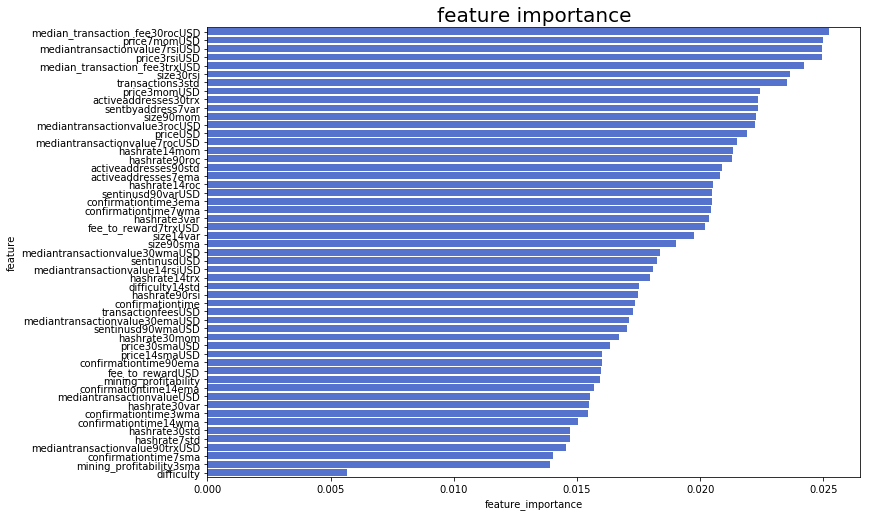

In [49]:
cmns.plot_feature_importance(imp_feat,'feature importance')

In [61]:
imp_feat[imp_feat['feature_importance']>0]


,feature,feature_importance
0,median_transaction_fee30rocUSD,0.025230
1,price7momUSD,0.024971
2,mediantransactionvalue7rsiUSD,0.024959
3,price3rsiUSD,0.024923
4,median_transaction_fee3trxUSD,0.024209
5,size30rsi,0.023626
6,transactions3std,0.023516
7,price3momUSD,0.022435
8,activeaddresses30trx,0.022342
9,sentbyaddress7var,0.022325


In [65]:
cols=[7,12,14,18,20,24,28,29,30,38,42,46]

In [66]:
#selected=imp_feat[imp_feat['feature_importance']>0.001]
#selected=imp_feat.filter(cols,axis=0)

In [67]:
selected=imp_feat.drop(cols,axis=0)

In [70]:
selected

,feature,feature_importance
0,median_transaction_fee30rocUSD,0.025230
1,price7momUSD,0.024971
2,mediantransactionvalue7rsiUSD,0.024959
3,price3rsiUSD,0.024923
4,median_transaction_fee3trxUSD,0.024209
5,size30rsi,0.023626
6,transactions3std,0.023516
8,activeaddresses30trx,0.022342
9,sentbyaddress7var,0.022325
10,size90mom,0.022259


In [71]:
selected.feature_importance.sum()

0.7733141898228453

In [72]:
X_high=X[selected.feature]

In [73]:
X_high.shape

(1097, 41)

In [74]:
X_high.sort_index(axis=1,inplace=True)

/home/mudassir/btcpaper/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


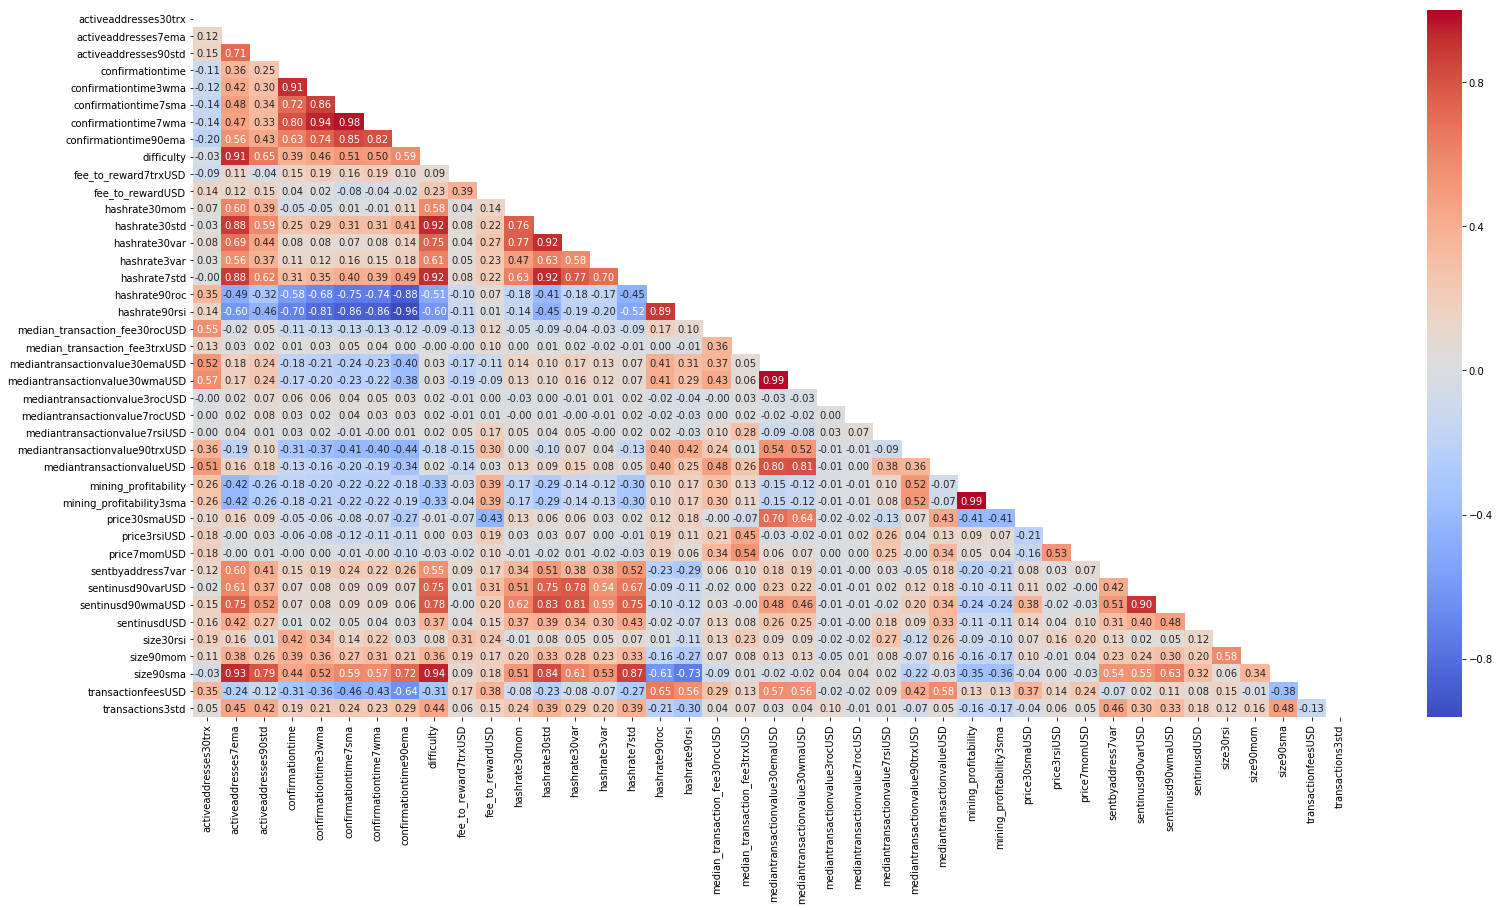

In [75]:
corr = X_high.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(26, 13))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

In [76]:
X_high['category']=np.ravel(y)

/home/mudassir/btcpaper/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
from sklearn.ensemble import IsolationForest
outlier=IsolationForest(contamination=0)
category=X_high['category']
category=category.values
category=np.reshape(category,(-1,1))
outlier.fit(category)
outs=outlier.predict(category)
X_high['outlier']=pd.DataFrame(zip(outs))
X_high=X_high.query('outlier != -1')
X_high.reset_index(drop=True,inplace=True)
X_high.drop(columns=['outlier'],inplace=True)

/home/mudassir/btcpaper/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [79]:
X_high.to_csv('cls_interval1.csv',sep=',',index=False)

In [80]:
X_high.columns

Index(['activeaddresses30trx', 'activeaddresses7ema', 'activeaddresses90std',
       'confirmationtime', 'confirmationtime3wma', 'confirmationtime7sma',
       'confirmationtime7wma', 'confirmationtime90ema', 'difficulty',
       'fee_to_reward7trxUSD', 'fee_to_rewardUSD', 'hashrate30mom',
       'hashrate30std', 'hashrate30var', 'hashrate3var', 'hashrate7std',
       'hashrate90roc', 'hashrate90rsi', 'median_transaction_fee30rocUSD',
       'median_transaction_fee3trxUSD', 'mediantransactionvalue30emaUSD',
       'mediantransactionvalue30wmaUSD', 'mediantransactionvalue3rocUSD',
       'mediantransactionvalue7rocUSD', 'mediantransactionvalue7rsiUSD',
       'mediantransactionvalue90trxUSD', 'mediantransactionvalueUSD',
       'mining_profitability', 'mining_profitability3sma', 'price30smaUSD',
       'price3rsiUSD', 'price7momUSD', 'sentbyaddress7var',
       'sentinusd90varUSD', 'sentinusd90wmaUSD', 'sentinusdUSD', 'size30rsi',
       'size90mom', 'size90sma', 'transactionfeesUSD', '